# Proposta de aplicação de análise de sobrevivência para o problema de churn na indústria de telecomunicações

In [253]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
import warnings
warnings.filterwarnings('ignore')


In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Estratégia de análise
* Preparação dos dados
  * Carregamento dos dados
  * Pré-processamento
    * Dados ausentes
    * Conversão de Tipo de Dados
    * Qualidade dos Dados
* Exploração dos dados e Visualização
  * Exploratory Data Analysis (EDA)
  * Anáise da taxa de churn e distribuição de tenure
  * Visualização das principais variáveis
* Análise de sobrevivência
  * Definição da variável de evento e tempo
    * Evento: Converter churn em um indicador binário
    * Tempo: Utilização da variável tenure como o tempo decorrido até o churn acontecer
* Modelo de Sobrevivência Multivariado - Cox Proportional Hazards Model
  * Preparação dos dados
  * Divisão dos dados em treino e teste
  * Treinamento do modelo
  * Validação do modelo
  * Explicabilidade do modelo

## Preparação dos dados
### Carregamento dos dados

Nosso cliente disponibilizou uma base de dados contendo 7.043 registros de clientes e 21 variáveis. 

O objetivo deste projeto é descobrir o comportamento de churn dos clientes, ou seja, quais clientes estão mais propensos a cancelar o serviço. 

Abaixo, segue uma descrição das variáveis disponíveis:

* customerID: Identificador único do cliente
* gender: Gênero do cliente, podendo ser Male e Female
* SeniorCitizen: Se o cliente é idoso ou não, podendo ser 0 ou 1
* Partner: Se o cliente tem parceiro ou não, podendo ser Yes ou No
* Dependents: Se o cliente tem dependentes ou não, podendo ser Yes ou No
* tenure: Quantidade de meses que o cliente permaneceu na empresa
* PhoneService: Se o cliente tem serviço de telefone ou não, podendo ser Yes ou No
* MultipleLines: Se o cliente tem múltiplas linhas de telefone ou não, podendo ser Yes, No ou No phone service
* InternetService: Se o cliente tem serviço de internet ou não, podendo ser DSL, Fiber optic ou No
* OnlineSecurity: Se o cliente tem serviço de segurança online ou não, podendo ser Yes, No ou No internet service
* OnlineBackup: Se o cliente tem serviço de backup online ou não, podendo ser Yes, No ou No internet service
* DeviceProtection: Se o cliente tem serviço de proteção de dispositivo ou não, podendo ser Yes, No ou No internet service
* TechSupport: Se o cliente tem serviço de suporte técnico ou não, podendo ser Yes, No ou No internet service
* StreamingTV: Se o cliente tem serviço de streaming de TV ou não, podendo ser Yes, No ou No internet service
* StreamingMovies: Se o cliente tem serviço de streaming de filmes ou não, podendo ser Yes, No ou No internet service
* Contract: Tipo de contrato do cliente, podendo ser Month-to-month, One year ou Two year
* PaperlessBilling: Se o cliente tem fatura sem papel ou não, podendo ser Yes ou No
* PaymentMethod: Método de pagamento do cliente, podendo ser Bank transfer (automatic), Credit card (automatic), Electronic check ou Mailed check
* MonthlyCharges: Valor da mensalidade do cliente
* TotalCharges: Valor total pago pelo cliente
* Churn: Se o cliente cancelou o serviço ou não, podendo ser Yes ou No

In [256]:
df = pd.read_csv('../data/raw/telecom_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

### Pré-processamento

#### Conversão de Tipo de Dados

Nesta etapa, iremos converter os tipos de dados das variáveis de acordo com os valores encontrados em cada uma delas. 

Temos três campos numéricos, sendo eles: tenure, MonthlyCharges e TotalCharges.

O campo customerID é um identificador único do cliente, portanto, não será utilizado na análise.

Os demais campos são todos categóricos. 


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

In [259]:
numeric_columns = ['MonthlyCharges', 'TotalCharges']
for c in numeric_columns:
    df[c] = df[c].str.replace(',', '.').astype(float)

df["tenure"] = pd.to_numeric(df["tenure"])


In [260]:
object_columns = df.select_dtypes(include="object").columns
for c in object_columns:
    df[c] = df[c].astype("category")

df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   category
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

#### Dados ausentes

Nesta etapa, iremos verificar se existem dados ausentes na base de dados.

In [261]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [262]:
df.isnull().sum()/df.shape[0]


customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

Foram encontrados dados ausentes apenas na coluna TotalCharges. 

Temos duas opções para tratar o problema de dados ausentes neste caso. 

A primeira opção seria remover os registros que possuem dados ausentes no campo TotalCharges. Como temos menos de 0,0016% de registros com dados ausentes, a remoção destes registros não afetaria a análise.

Uma segunda opção seria preencher os dados ausentes com uma estimativa de valor para o campo TotalCharges. Neste caso, seria necessário entender melhor a distribuição dos valores de TotalCharges para decidir qual seria a melhor estratégia de preenchimento. Uma hipótese que podemos levantar é que os valores de TotalCharges são próximos do valor de quantidade de meses de permanência na empresa multiplicado pelo valor MonthlyCharges. 

Para essa análise, vamos filtrar apenas os registros que não possuem dados ausentes no campo TotalCharges.


In [263]:
df_inputation_totalCharges = df[df["TotalCharges"].notnull()]

Vamos então calcular o valor de TotalCharges por meio da fórmula abaixo:

totalCharges_cal = tenure * MonthlyCharges

E em seguida verificar o quão próximo o valor calculado está do valor real de TotalCharges.

In [264]:
df_inputation_totalCharges["totalCharges_calc"] = df_inputation_totalCharges["MonthlyCharges"] * \
    df_inputation_totalCharges["tenure"]
    
# módulo da diferença entre o valor real e o calculado
df_inputation_totalCharges["totalCharges_calc_error"] = df_inputation_totalCharges["TotalCharges"] - df_inputation_totalCharges["totalCharges_calc"]
df_inputation_totalCharges["totalCharges_calc_error_abs"] = abs(df_inputation_totalCharges["TotalCharges"] - df_inputation_totalCharges["totalCharges_calc"])
df_inputation_totalCharges["totalCharges_calc_error_abs_perc"] = (df_inputation_totalCharges["totalCharges_calc_error_abs"] / df_inputation_totalCharges["TotalCharges"])*100


In [265]:
df_inputation_totalCharges[["TotalCharges", "MonthlyCharges", "tenure",
                            "totalCharges_calc", "totalCharges_calc_error", "totalCharges_calc_error_abs", "totalCharges_calc_error_abs_perc"]].head()



,TotalCharges,MonthlyCharges,tenure,totalCharges_calc,totalCharges_calc_error,totalCharges_calc_error_abs,totalCharges_calc_error_abs_perc
0,8672.45,118.75,72,8550.00,122.45,122.45,1.411942
1,8477.60,118.65,71,8424.15,53.45,53.45,0.630485
2,7990.05,118.60,68,8064.80,-74.75,74.75,0.935539
3,7365.70,118.60,61,7234.60,131.10,131.10,1.779872
4,7804.15,118.35,67,7929.45,-125.30,125.30,1.605556


In [266]:
df_inputation_totalCharges[["TotalCharges", "MonthlyCharges", "tenure",
                            "totalCharges_calc", "totalCharges_calc_error", "totalCharges_calc_error_abs", "totalCharges_calc_error_abs_perc"]].describe()


,TotalCharges,MonthlyCharges,tenure,totalCharges_calc,totalCharges_calc_error,totalCharges_calc_error_abs,totalCharges_calc_error_abs_perc
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,2283.300441,64.798208,32.421786,2283.147248,0.153193,45.089157,3.214793
std,2266.771362,30.085974,24.545260,2264.703327,67.255326,49.899711,4.002725
min,18.800000,18.250000,1.000000,18.800000,-370.850000,0.000000,0.000000
25%,401.450000,35.587500,9.000000,397.800000,-28.650000,9.437500,0.722129
50%,1397.475000,70.350000,29.000000,1394.575000,0.000000,28.650000,1.995528
75%,3794.737500,89.862500,55.000000,3791.250000,28.700000,63.700000,4.209919
max,8684.800000,118.750000,72.000000,8550.000000,373.250000,373.250000,45.062837


<Axes: >

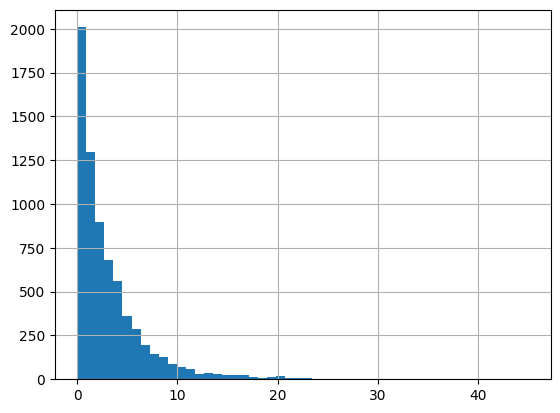

In [267]:
df_inputation_totalCharges["totalCharges_calc_error_abs_perc"].hist(bins=50)

Realizando uma análise descritiva dos dados, podemos observar que a diferença entre o valor TotalCharges calculado e o valor real de TotalCharges é menor que 4,3% para 75% dos registros. Sendo a diferença em média 3,22%. 

Desta forma, podemos utilizar esta estratégia para preencher os dados ausentes no campo TotalCharges.

Ainda sobre essa análise, foi possível identificar que existem alguns outliers com valores de totalCharges_calc_error_perc maiores que 10%. Este comportamento pode indicar a presenção de outras variáveis externas que poderiam influenciar no valor de TotalCharges, como por exemplo: juros, multas, descontos, etc. Tais variáveis não estão disponíveis na base de dados, portanto, não será possível realizar uma análise mais aprofundada sobre este comportamento.

In [268]:
# TotalCharges = MonthlyCharges * tenure
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

df.isnull().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [269]:
df.describe(include="category")

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,0002-ORFBO,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


#### Remoção do identificador de cliente

O identificador de cliente não será utilizado na análise, portanto, será removido da base de dados.

In [270]:
df = df.drop("customerID", axis=1)

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

#### Qualidade dos Dados

Para os dados numéricos, iremos verificar a distribuição dos dados com o objetivo de identificar possíveis outliers.

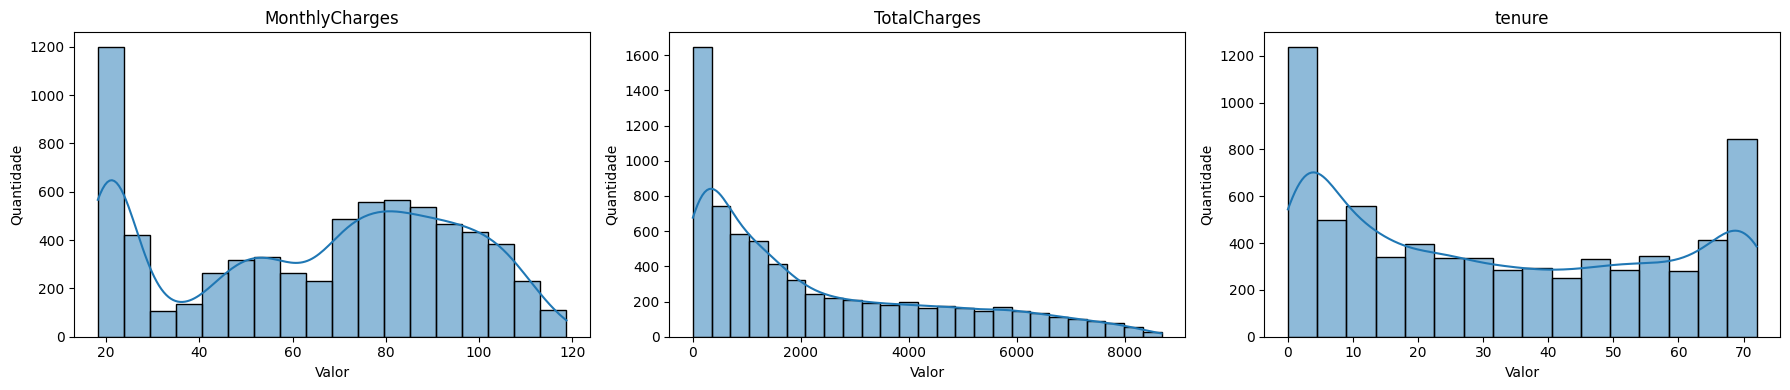

In [272]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']

# Plot the distribution of numerical variables
plt.figure(figsize=(18, 4))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=column, kde=True)
    plt.title(column)
    plt.xlabel("Valor")
    plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

Ao analisar a distribuição dos campos numéricos, não foi possível identificar nenhum outlier que possa impactar na análise.

## Exploração dos dados e Visualização

### Exploratory Data Analysis (EDA)

Nesta etapa, iremos realizar uma análise exploratória dos dados com o objetivo de entender melhor o comportamento dos dados e identificar possíveis insights.

#### Taxa de Churn

A taxa de churn é a proporção de clientes que cancelaram o serviço em relação ao total de clientes.

Taxa de Churn:
 Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


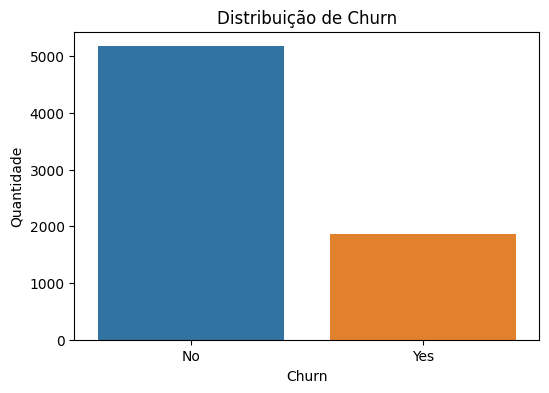

In [273]:
# Calculate churn rate
churn_rate = df['Churn'].value_counts(normalize=True) * 100

# Display the churn rate
print("Taxa de Churn:\n", churn_rate)

# Plot the churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title("Distribuição de Churn")
plt.xlabel("Churn")
plt.ylabel("Quantidade")
plt.show()


Identificamos uma taxa de Churn de 26,5% na base de dados. Como não temos informações sobre o período de tempo em que os dados foram coletados, não é possível estimar uma taxa de Churn mensal ou anual. Podemos considerar que a taxa de Churn encontrada é a taxa de Churn total.

#### Distribuição das variáveis categóricas com relação ao Churn

Nesta etapa, iremos analisar a distribuição das variáveis categóricas com relação ao Churn. Com isso, poderemos identificar possíveis padrões de comportamento dos clientes que cancelaram o serviço.

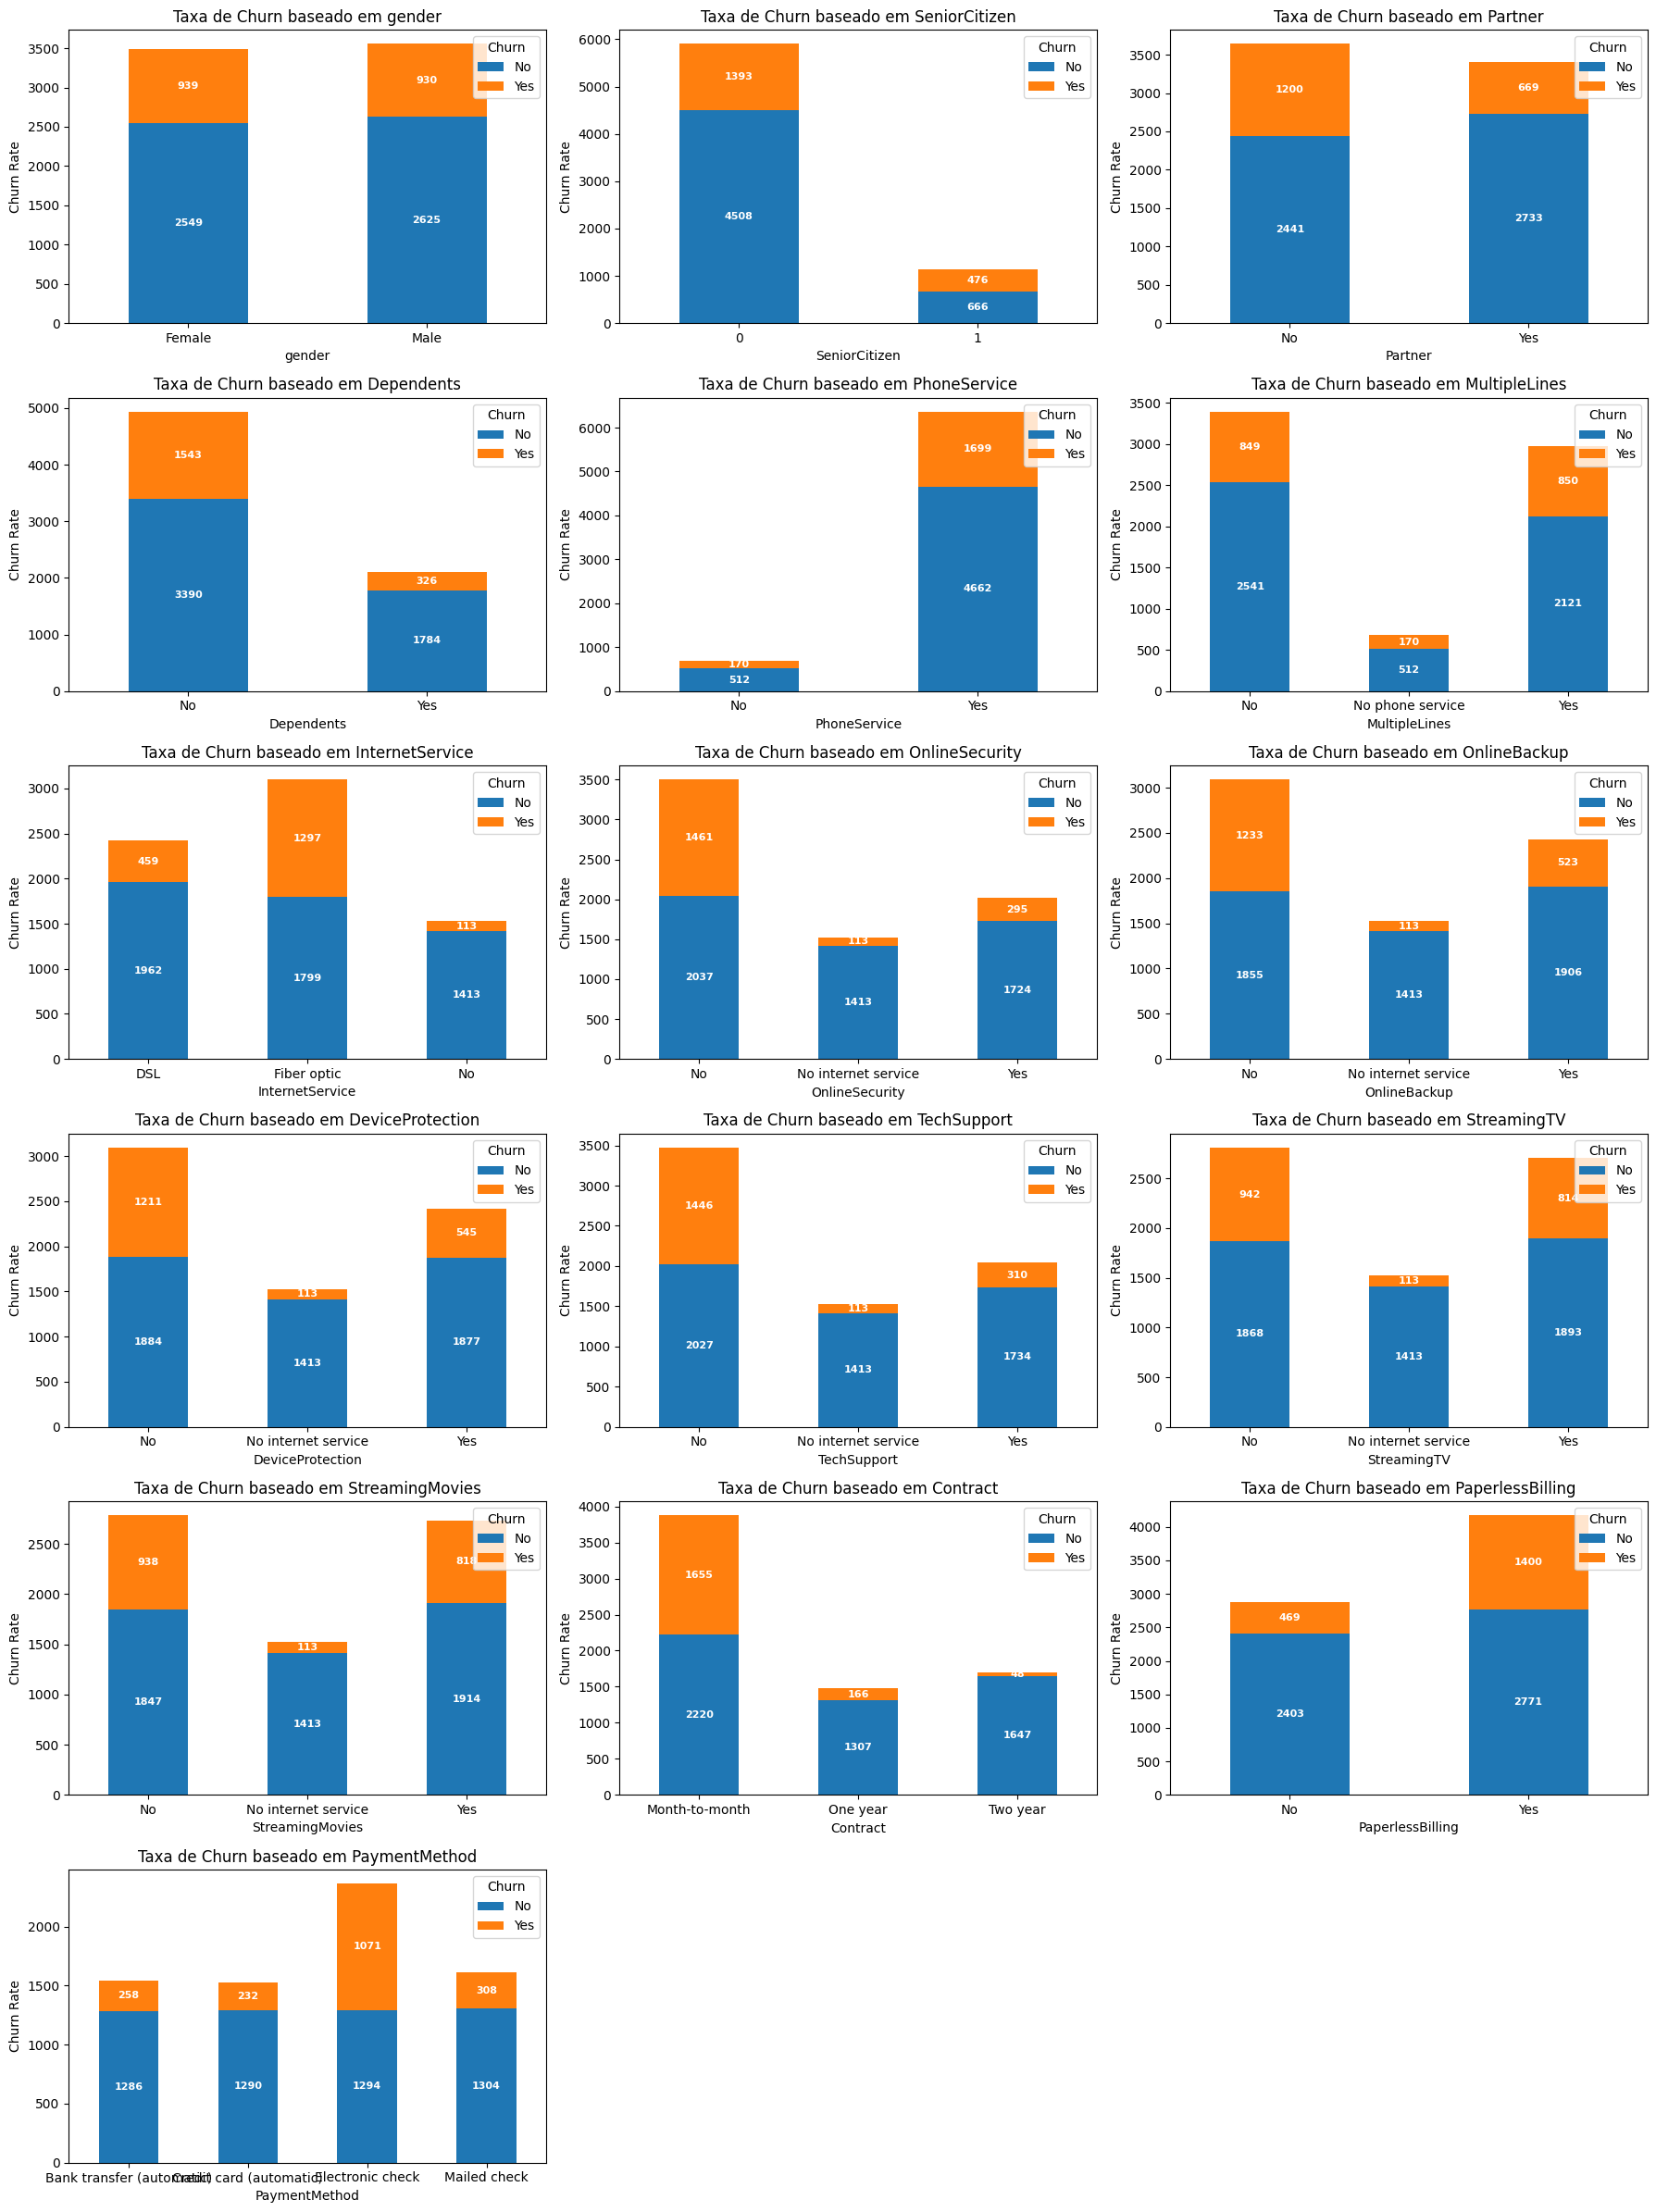

In [274]:
category_columns = df.select_dtypes(include="category").columns

# Plot churn rate based on each categorical variable
plt.figure(figsize=(18, 24))

for i, column in enumerate(category_columns[:-1], 1):
    plt.subplot(6, 3, i)
    churn_rate_by_category = df.groupby(
        column)['Churn'].value_counts().unstack()
    bar_plot = churn_rate_by_category.plot(
        kind='bar', stacked=True, ax=plt.gca())

    plt.title(f"Taxa de Churn baseado em {column}")
    plt.xlabel(column)
    plt.ylabel("Churn Rate")
    plt.legend(title='Churn', loc='upper right')
    plt.xticks(rotation=0)

    # Adicionar os valores reais
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            width = bar.get_width()
            x = bar.get_x()
            y = bar.get_y()
            value = int(height)
            plt.annotate(value, (x + width / 2, y + height / 2),
                         ha='center', va='center', color='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [275]:
for col in df.columns:
    if df[col].dtype == 'category':
        print(f'{df[col].value_counts(normalize=True)}')


gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64
SeniorCitizen
0    0.837853
1    0.162147
Name: proportion, dtype: float64
Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64
Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64
PhoneService
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64
InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: proportion, dtype: float64
OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64
OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: proportion, dtype: float64
DeviceProtection
No                     0.439443
Yes                    0.34388

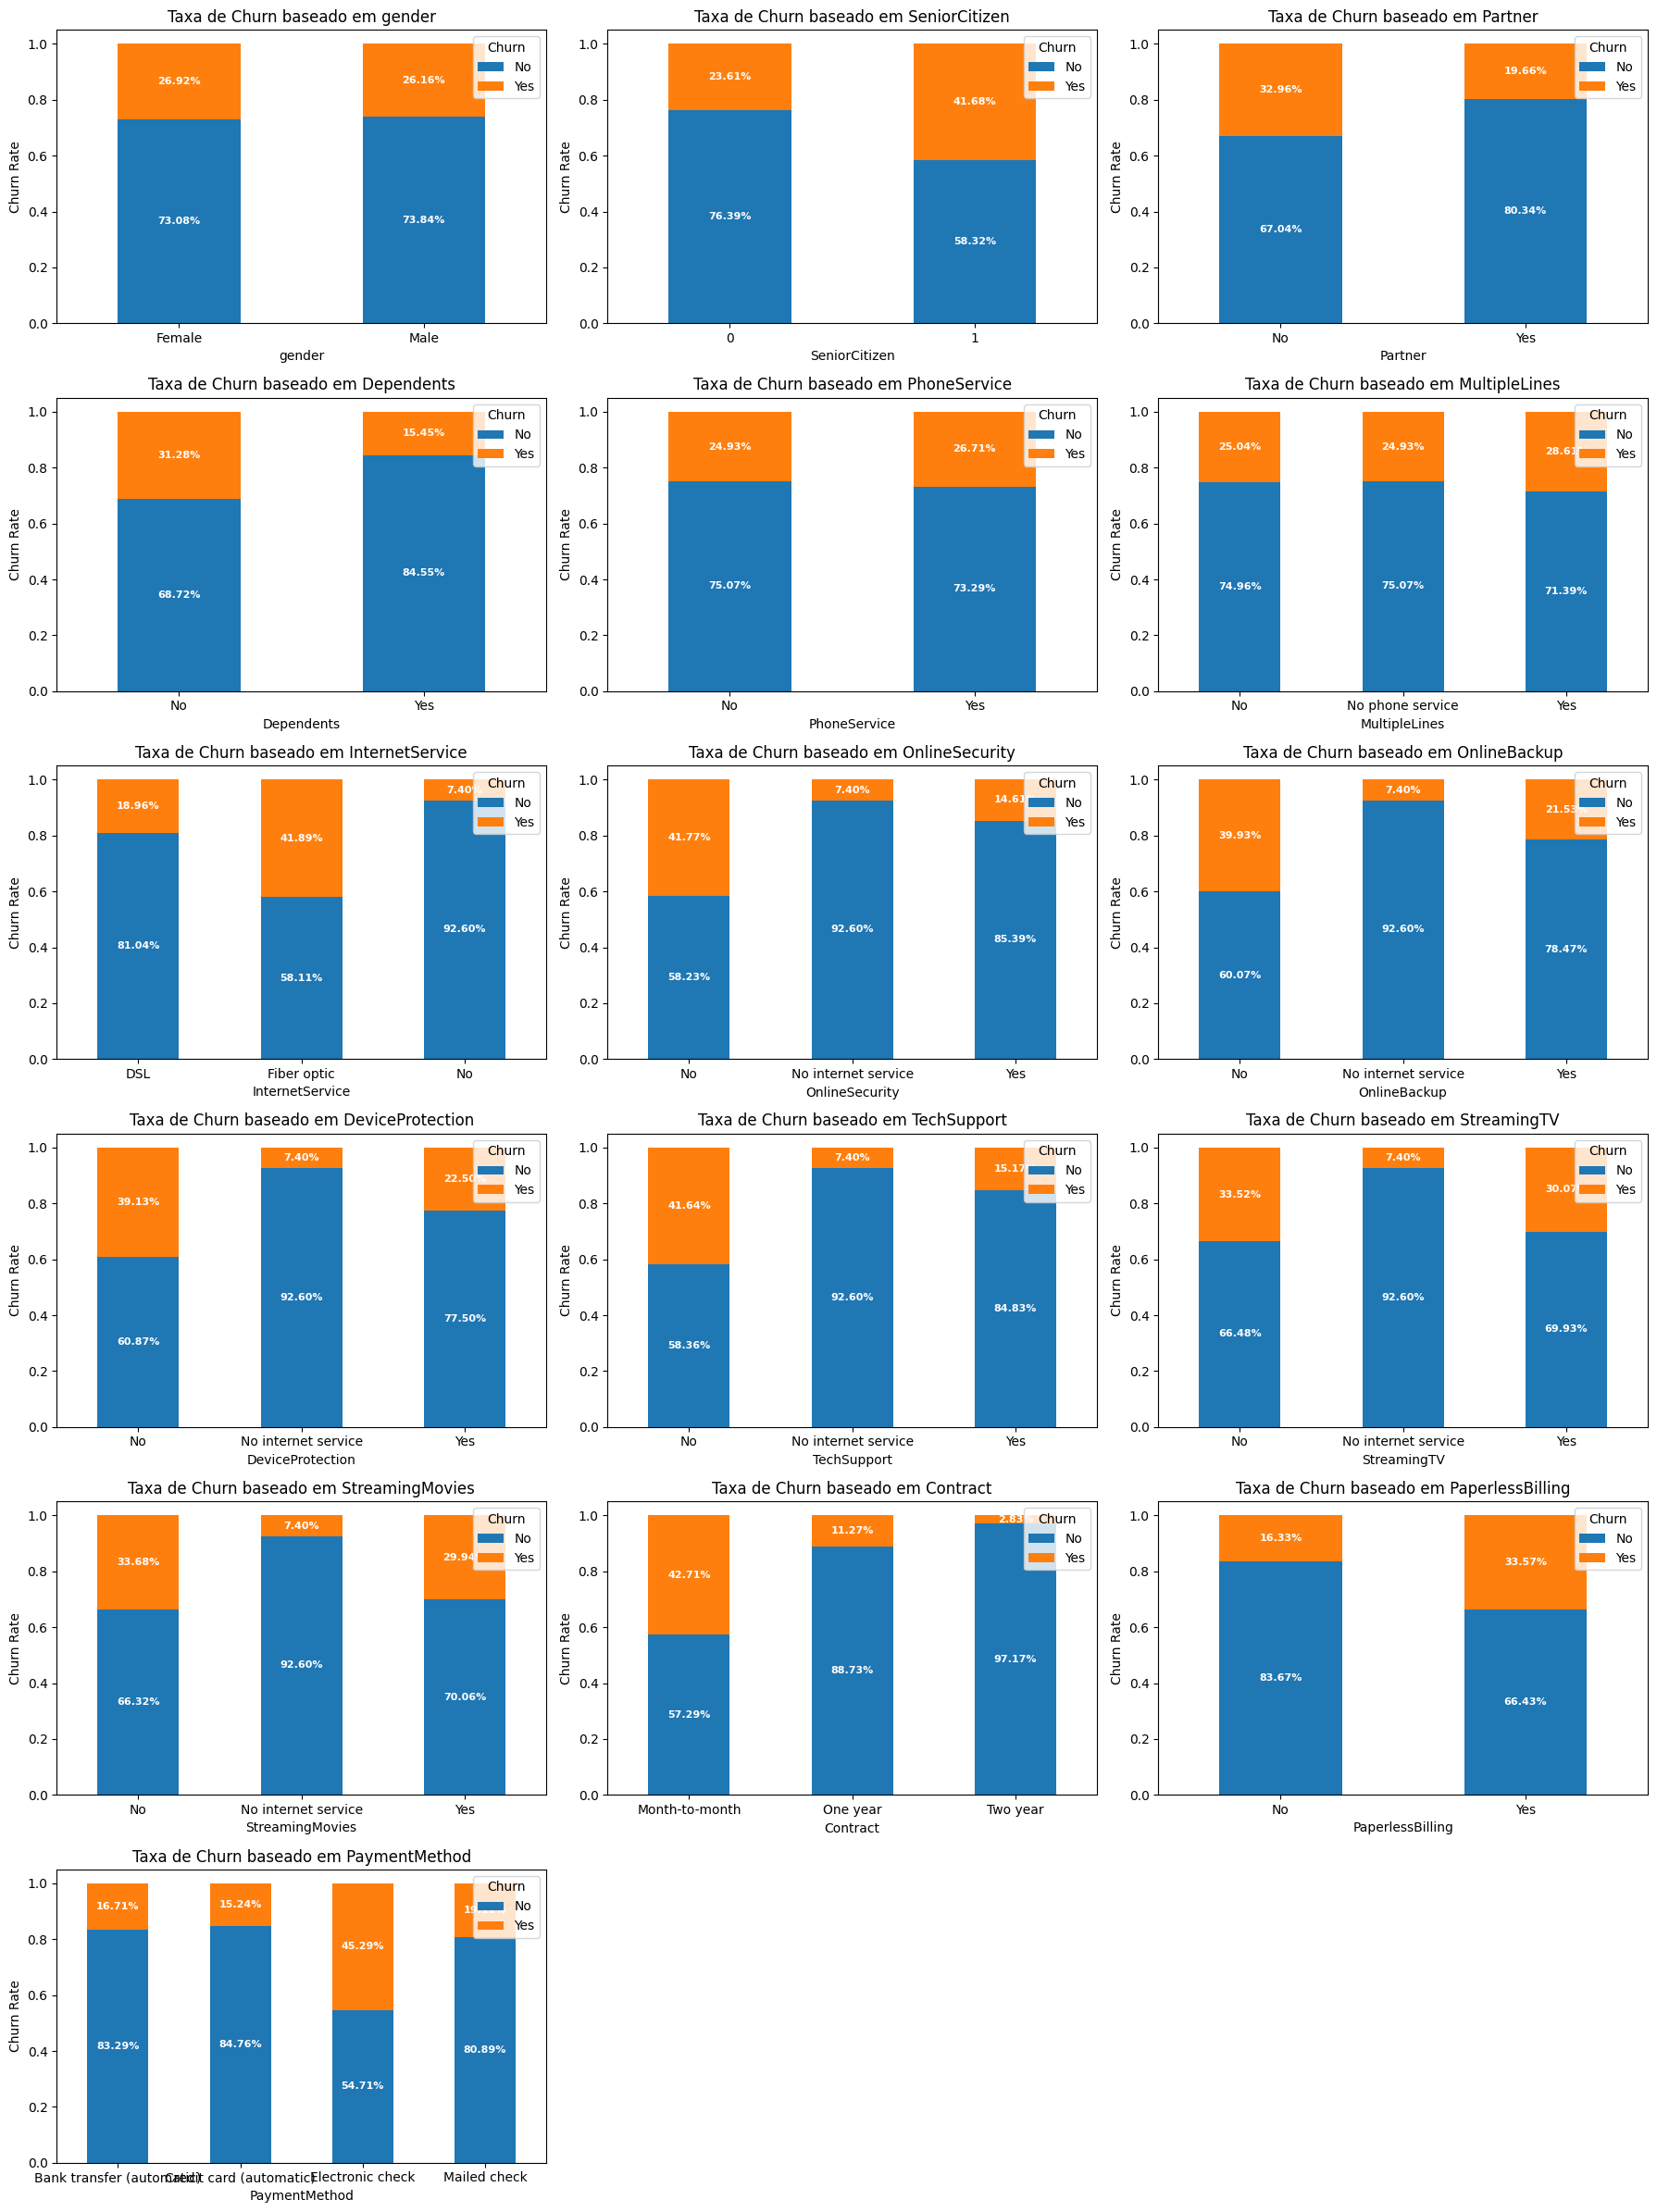

In [276]:
category_columns = df.select_dtypes(include="category").columns

# Plot churn rate based on each categorical variable
plt.figure(figsize=(18, 24))

for i, column in enumerate(category_columns[:-1], 1):
    plt.subplot(6, 3, i)
    churn_rate_by_category = df.groupby(
        column)['Churn'].value_counts(normalize=True).unstack()
    bar_plot = churn_rate_by_category.plot(
        kind='bar', stacked=True, ax=plt.gca())

    plt.title(f"Taxa de Churn baseado em {column}")
    plt.xlabel(column)
    plt.ylabel("Churn Rate")
    plt.legend(title='Churn', loc='upper right')
    plt.xticks(rotation=0)

    # Adicionar as anotações de porcentagem
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            width = bar.get_width()
            x = bar.get_x()
            y = bar.get_y()
            churn_percentage = f"{height * 100:.2f}%"
            plt.annotate(churn_percentage, (x + width / 2, y + height / 2),
                         ha='center', va='center', color='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


Analisando cuidadosamente a distribuição das variáveis com relação ao Churn, podemos identificar alguns padrões de comportamento dos clientes que cancelaram o serviço.

* Gender: Importante identificar que a distribuição de gênero dos clientes é balanceada, ou seja, temos uma quantidade similar de clientes do gênero masculino e feminino. Infelizmente não existe a inclusão de outras opções de gênero na base de dados, indicando que possívelmente estes dados podem não retratar a realidade da população. Além disso, por se tratar de uma variável sensível, ela não será utilizada na análise.
* SeniorCitizen: Apenas 16% dos clientes foram identificados como idosos. Apesar da taxa de churn entre os idosos ser de cerca de 41%, enquanto que entre os não idosos é de cerca de 23%. A maior proporção de churn dentre os idosos pode estar relacionada à variáveis externas que não estão disponíveis na base de dados.
* Partner: Aproximadamente 48% dos clientes possuem parceiros. A taxa de churn entre os clientes que possuem parceiros é de cerca de 19%, enquanto que entre os clientes que não possuem parceiros é de cerca de 33%. A maior proporção de churn dentre os clientes que não possuem parceiros pode estar relacionada ao nível de satisfação do cliente com relação ao parceiro. Entretanto seria necessário explorar melhor esta variável para entender melhor o comportamento dos clientes que possuem parceiros.
* Dependents: Aproximadamente 30% dos clientes possuem dependentes. A taxa de churn entre os clientes que possuem dependentes é de cerca de 16%, enquanto que entre os clientes que não possuem dependentes é de cerca de 31%.
* PhoneService: Aproximadamente 90% dos clientes possuem serviço de telefone. A taxa de churn entre os clientes que possuem serviço de telefone é de cerca de 25%, enquanto que entre os clientes que não possuem serviço de telefone é de cerca de 27%.
* MultipleLines: Aproximadamente 42% dos clientes possuem múltiplas linhas de telefone. A taxa de churn entre os clientes que possuem múltiplas linhas de telefone é de cerca de 29%, enquanto que entre os clientes que não possuem múltiplas linhas de telefone é de cerca de 25%.
* InternetService: Aproximadamente 78% dos clientes possuem serviço de internet. Sendo que 44% possuem fibra ótica e 34% possuem DSL. A taxa de churn entre os clientes que possuem fibra ótica é de cerca de 41%, enquanto que entre os clientes que possuem DSL é de cerca de 19%. A maior proporção de churn dentre os clientes que possuem fibra ótica pode estar relacionada a algum problema de qualidade do serviço de fibra ótica. Entretanto seria necessário explorar melhor esta variável para entender melhor o comportamento dos clientes que possuem fibra ótica.
* OnlineSecurity: Aproximadamente 50% dos clientes não possuem o serviço de segurança online. A taxa de churn entre os clientes que possuem o serviço de segurança online é de cerca de 15%, enquanto que entre os clientes que não possuem o serviço é de cerca de 42%. A menor proporção de churn dentre os clientes que possuem o serviço pode indicar um certo nível de fidelidade e confiança dos clientes com relação aos serviços prestados pela empresa.
* OnlineBackup: Aproximadamente 44% dos clientes não possuem o serviço de backup online. A taxa de churn entre os clientes que possuem o serviço de backup online é de cerca de 22%, enquanto que entre os clientes que não possuem o serviço é de cerca de 39%.
* DeviceProtection: Aproximadamente 44% dos clientes não possuem o serviço de proteção de dispositivo. A taxa de churn entre os clientes que possuem o serviço de proteção de dispositivo é de cerca de 22%, enquanto que entre os clientes que não possuem o serviço é de cerca de 39%.
* TechSupport: Aproximadamente 50% dos clientes não possuem o serviço de suporte técnico. A taxa de churn entre os clientes que possuem o serviço de suporte técnico é de cerca de 15%, enquanto que entre os clientes que não possuem o serviço é de cerca de 42%.
* StreamingTV: Aproximadamente 40% dos clientes não possuem o serviço de streaming de TV. A taxa de churn entre os clientes que possuem o serviço de streaming de TV é de cerca de 24%, enquanto que entre os clientes que não possuem o serviço é de cerca de 33%.
* StreamingMovies: Aproximadamente 40% dos clientes não possuem o serviço de streaming de filmes. A taxa de churn entre os clientes que possuem o serviço de streaming de filmes é de cerca de 24%, enquanto que entre os clientes que não possuem o serviço é de cerca de 33%.
* Contract: Aproximadamente 55% dos clientes possuem contrato mensal. A taxa de churn entre os clientes que possuem contrato mensal é de cerca de 43%, enquanto que entre os clientes que possuem contrato anual é de cerca de 11% e entre os clientes que possuem contrato bianual é de cerca de 2%. A menor proporção de churn dentre os clientes que possuem contratos anual e bianual pode indicar um certo nível de fidelidade e confiança dos clientes com relação aos serviços prestados pela empresa.
* PaperlessBilling: Aproximadamente 59% dos clientes possuem faturamento sem papel. A taxa de churn entre os clientes que possuem faturamento sem papel é de cerca de 34%, enquanto que entre os clientes que possuem faturamento com papel é de cerca de 17%.
* PaymentMethod: Foi possível identificar que a proporção de clientes que optam por cada uma das formas de pagamento é similar. Entretanto, a proporção de churn entre os clientes que optam pela forma de pagamento por cheque eletrônico é de cerca de 45%. Este percentual elevado indica a necessidade de uma análise mais detalhada desta forma de pagamento.

In [277]:
df = df.drop("gender", axis=1)

#### Análise de sobrevivência - Survival Analysis

A Análise de Sobrevivência é uma técnica estatística utilizada para estudar o tempo até a ocorrência de um evento, geralmente relacionado à sobrevivência ou à falha de algum evento em um determinado período de tempo. Também é conhecida como análise de tempo até o evento, análise de tempo de falha ou análise de tempo de vida.

Essa técnica é frequentemente aplicada em estudos de saúde, medicina, ciências sociais e engenharia para analisar o tempo até a morte, o tempo até a recuperação, o tempo até a falha de um sistema ou qualquer outro evento de interesse. A Análise de Sobrevivência leva em consideração o tempo de ocorrência do evento, a presença de censuras (dados incompletos) e a relação entre variáveis explicativas e a probabilidade de ocorrência do evento.

Um aspecto fundamental da análise de sobrevivência é o uso da função de sobrevivência, que descreve a probabilidade de um indivíduo ou unidade ainda estar "sobrevivendo" até um determinado tempo. Além disso, o método também envolve o uso de curvas de sobrevivência, que mostram a proporção de indivíduos que ainda não experimentaram o evento em função do tempo.

Existem várias técnicas estatísticas utilizadas na análise de sobrevivência, como o modelo de riscos proporcionais de Cox, que permite examinar o efeito de múltiplas variáveis explicativas no tempo de ocorrência do evento. Outros métodos, como o método de Kaplan-Meier e os modelos paramétricos, também são amplamente utilizados.

Em resumo, a análise de sobrevivência é uma técnica estatística poderosa para estudar o tempo até a ocorrência de eventos e permite a avaliação de fatores que influenciam a probabilidade de um evento ocorrer ao longo do tempo.

Vamos utilizar a análise de sobrevivência para estudar o tempo até a ocorrência do evento de churn. Para isso, vamos utilizar o método de Kaplan-Meier, que é um método não paramétrico para estimar a função de sobrevivência. Precisamos para tal identificar as variáveis de tempo e evento no cenário de churn. Utilizaremos a variável tenure como variável de tempo e a variável churn como variável de evento.

Text(0.5, 0, 'time $t$')

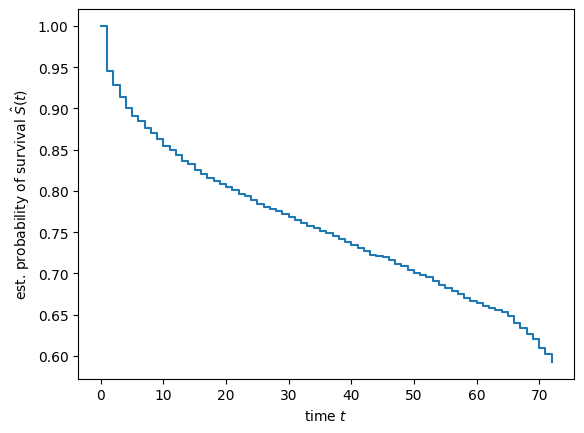

In [278]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(
    df["Churn"].map({'Yes':True, 'No': False}), df["tenure"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


Analisando a curva de sobrevivência, podemos observar que a probabilidade de um cliente permanecer na empresa é de 80% após 12 meses de contrato. A probabilidade de sobrevivência reduz quase linearmente após 12 meses de contrato, chegando a 60% após 70 meses de contrato. 

Entretanto, é importante salientar que existe uma queda de aproximadamente 5% na probabilidade de sobrevivência entre o 1º e o 2º mês de contrato. Este comportamento indica a necessidade de uma análise mais detalhada do que pode estar causando esta queda drástica logo no início do contrato.

Para poder entender melhor este comportamento, iremos considerar outras variáveis e comparar suas curvas de sobrevivência.

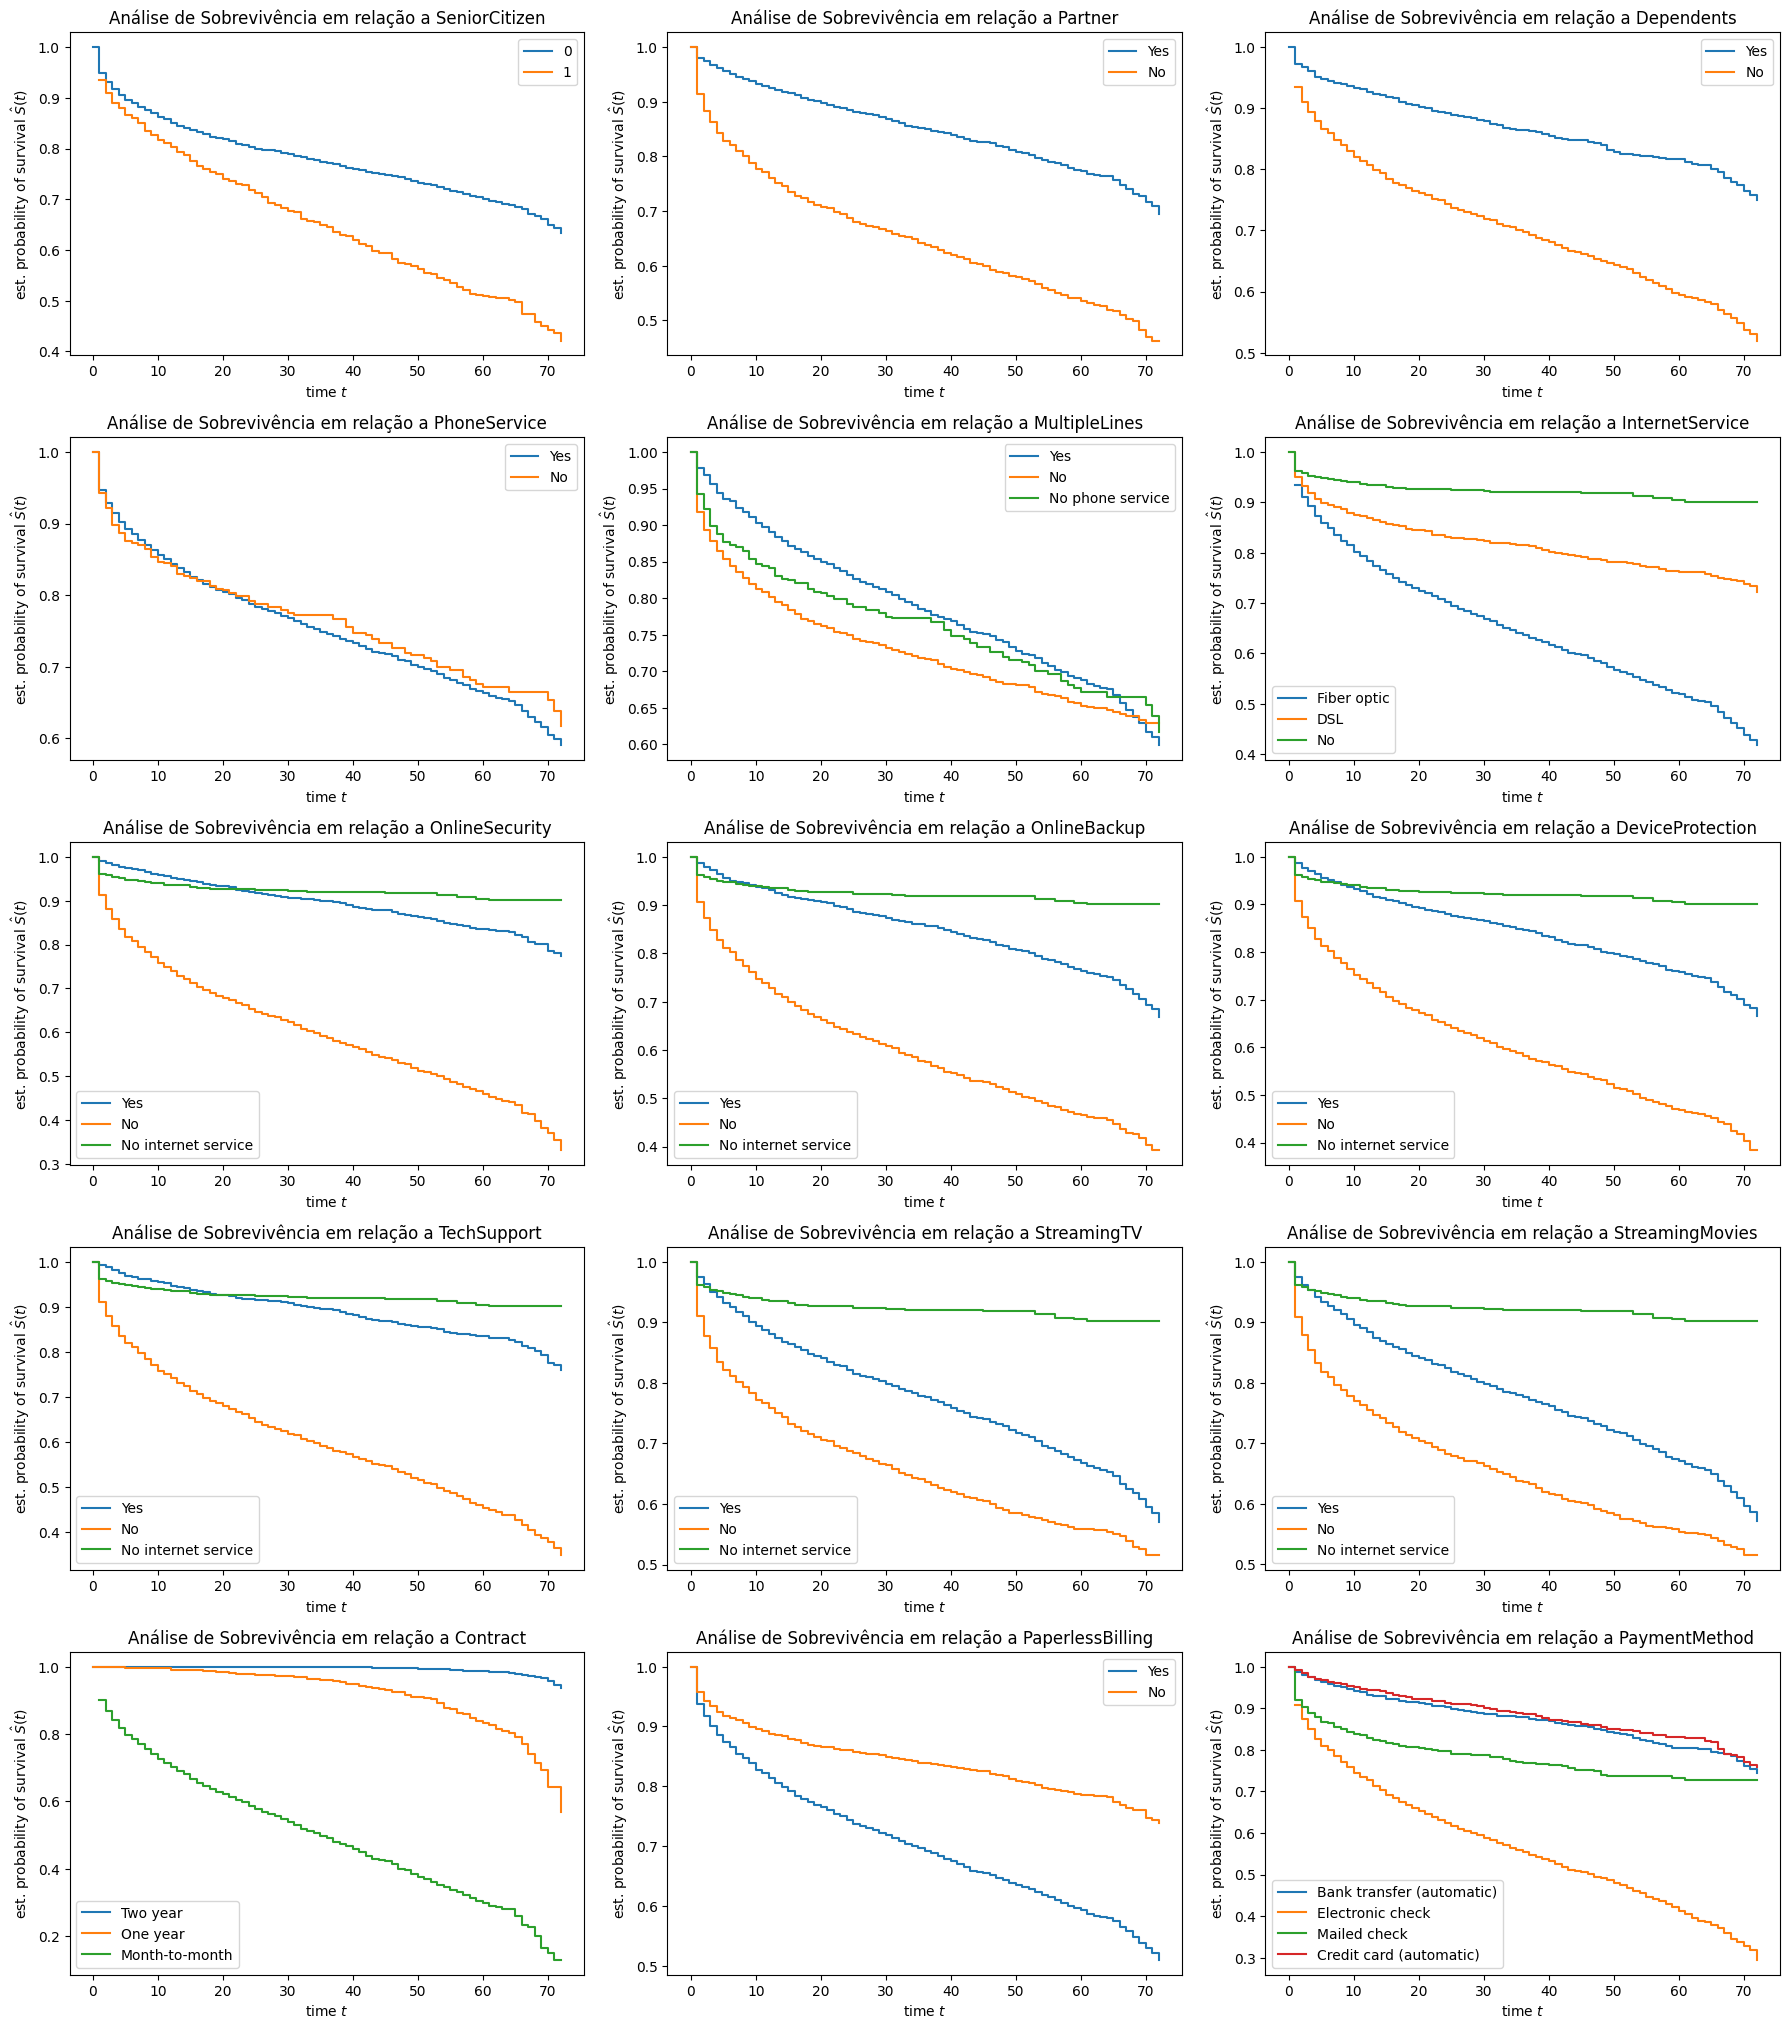

In [279]:
category_columns = df.select_dtypes(include="category").columns

plt.figure(figsize=(18, 24))

for i, column in enumerate(category_columns[:-1], 1):
    plt.subplot(6, 3, i)

    for category in df[column].unique():
        mask = df[column] == category
        time, survival_prob = kaplan_meier_estimator(
            df["Churn"][mask].map({'Yes':True, 'No': False}), df["tenure"][mask])
        plt.step(time, survival_prob, where="post", label=category)
    
    plt.title(f"Análise de Sobrevivência em relação a {column}")    
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


Mesmo que o método de análise visual não seja o mais recomendado para comparar as curvas de sobrevivência, podemos observar alguns comportamentos relevantes para a análise de churn. 

Por exemplo, podemos observar que a curva de sobrevivência dos clientes que possuem contrato mensal é bem diferente da curva de sobrevivência dos clientes que possuem contrato anual ou bianual. A probabilidade de sobrevivência dos clientes que possuem contrato mensal é de 60% após 12 meses de contrato, enquanto que a probabilidade de sobrevivência dos clientes que possuem contrato anual ou bianual é de 90% após 12 meses de contrato.

Outra comparação que pode ser feita é com relação ao meio de pagamento. A curva de sobrevivência dos clientes que optam pelo meio de pagamento "cheque enviado pelo correio" apresenta o mesmo comportamento de churn entre o 1º e o 2º mês de contrato. Como este meio de pagamento é o menos seguro dentre os demais, é possível que a empresa esteja tendo algum problema referente ao envio e recebimento dos cheques, ou até mesmo exista um ponto de fraude nestes contratos. Uma hipótese é de que, ao receber uma cobrança pela qual o cliente não reconhece a contratação do serviço, o cliente solicita o cancelamento imediato e abre um procedimento de fraude junta à empresa. Para validar esta hipótese é necessário um estudo mais detalhado do perfil destes clientes.

### Modelo de Sobrevivência Multivariado - Cox Proportional Hazards Model

Os modelos multivariados de sobrevivência se referem a modelos estatísticos usados para analisar e prever os resultados de sobrevivência ou tempo até um evento ocorrer de múltiplos indivíduos ou entidades, levando em consideração a relação entre várias variáveis ou covariáveis. O foco desta técnica está na análise dos padrões de sobrevivência de múltiplos indivíduos ou entidades simultaneamente, considerando as possíveis interações e dependências entre várias covariáveis ou preditores. Esses modelos são frequentemente usados em pesquisa biomédica, epidemiologia, ciências atuariais e outras áreas em que analisar dados de tempo até o evento com múltiplos preditores é de interesse.

Os modelos multivariados de sobrevivência podem incorporar tanto covariáveis categóricas quanto contínuas, permitindo que os pesquisadores examinem os efeitos de vários fatores nos resultados de sobrevivência. Eles levam em conta a censura, que é uma característica comum dos dados de sobrevivência, em que o evento de interesse ainda não ocorreu para alguns indivíduos no final do estudo ou período de coleta de dados.

Existem vários tipos de modelos multivariados de sobrevivência, incluindo o modelo de riscos proporcionais de Cox, modelos de sobrevivência paramétricos (como o modelo Weibull ou exponencial) e modelos de fragilidade. Esses modelos fornecem estimativas de razões de risco, que quantificam o efeito de cada covariável no risco de ocorrência do evento. Eles também permitem a estimativa de curvas de sobrevivência e a previsão de probabilidades futuras de eventos para indivíduos ou grupos com base em seus valores de covariáveis.

Em resumo, os modelos multivariados de sobrevivência fornecem uma ferramenta poderosa para analisar e compreender a relação entre várias variáveis e resultados de sobrevivência. Eles ajudam os pesquisadores a obter insights sobre os fatores que influenciam o tempo até a ocorrência de um evento e podem ser usados para previsão, avaliação de riscos e tomada de decisões em várias áreas.

Mais importante que identificar um comportamento de churn é prever quando este evento irá ocorrer. Deste modo, a empresa pode tomar ações preventivas para evitar que o cliente cancele o contrato. Para isso, iremos utilizar o modelo de riscos proporcionais de Cox, que permite examinar o efeito de múltiplas variáveis explicativas no tempo de ocorrência do evento.

#### Preparação dos dados

Para utilizar o modelo de riscos proporcionais de Cox, precisamos preparar os dados de forma que cada linha represente um cliente e cada coluna represente uma variável. Além disso, precisamos transformar as variáveis categóricas em variáveis dummy, ou seja, variáveis binárias que indicam a presença ou ausência de uma categoria.

In [280]:
from sksurv.preprocessing import OneHotEncoder

yes_no_cols = ['Partner', 'Dependents',
               'PhoneService', 'PaperlessBilling', 'Churn']

df_dummy = df[category_columns].copy()

df_dummy['SeniorCitizen'] = df_dummy['SeniorCitizen'].astype(float)

for col in yes_no_cols:
    df_dummy[col] = df_dummy[col].map({'Yes': 1, 'No': 0}).astype(float)

not_yes_no_cols = list(set(category_columns) - set(yes_no_cols) - set(['SeniorCitizen']))
    
df_dummy = pd.get_dummies(df_dummy, columns=not_yes_no_cols, dtype=float)
df_dummy.head()


,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes
0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Para o treinamento do modelo de sobrevivência multivariado, precisamos garantir que não exista colinearidade entre as variáveis explicativas. Ao analisar a matriz de correlação podemos identificar que as variáveis dummy referentes ao valor "no service" apresenta colinearidade com as variáveis dummy referentes ao serviço de internet ou telefone. Para evitar este problema, iremos remover as variáveis dummy referentes ao valor "no service".

In [281]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   float64
 1   Partner                                  7043 non-null   float64
 2   Dependents                               7043 non-null   float64
 3   PhoneService                             7043 non-null   float64
 4   PaperlessBilling                         7043 non-null   float64
 5   Churn                                    7043 non-null   float64
 6   StreamingMovies_No                       7043 non-null   float64
 7   StreamingMovies_No internet service      7043 non-null   float64
 8   StreamingMovies_Yes                      7043 non-null   float64
 9   StreamingTV_No                           7043 non-null   float64
 10  StreamingTV_No internet service          7043 no

In [282]:
# Calculate the correlation matrix
correlation_matrix = df_dummy.corr()

# Obtém as colunas a serem removidas (correlação igual a 1)
columns_to_remove = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) == 1:
            column = correlation_matrix.columns[j]
            columns_to_remove.append(column)

# Remove as colunas do DataFrame
df_dummy = df_dummy.drop(columns=columns_to_remove)
df_dummy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   float64
 1   Partner                                  7043 non-null   float64
 2   Dependents                               7043 non-null   float64
 3   PhoneService                             7043 non-null   float64
 4   PaperlessBilling                         7043 non-null   float64
 5   Churn                                    7043 non-null   float64
 6   StreamingMovies_No                       7043 non-null   float64
 7   StreamingMovies_No internet service      7043 non-null   float64
 8   StreamingMovies_Yes                      7043 non-null   float64
 9   StreamingTV_No                           7043 non-null   float64
 10  StreamingTV_Yes                          7043 no

#### Divisão dos dados em treino e teste

In [283]:
X = df_dummy.drop('Churn', axis=1)
df['Churn'] = df['Churn'].map({'Yes':True, 'No': False})
y = df[['Churn', 'tenure']].to_records(index=False)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=974)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4930, 30), (2113, 30), (4930,), (2113,))

In [285]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4930 entries, 187 to 4280
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            4930 non-null   float64
 1   Partner                                  4930 non-null   float64
 2   Dependents                               4930 non-null   float64
 3   PhoneService                             4930 non-null   float64
 4   PaperlessBilling                         4930 non-null   float64
 5   StreamingMovies_No                       4930 non-null   float64
 6   StreamingMovies_No internet service      4930 non-null   float64
 7   StreamingMovies_Yes                      4930 non-null   float64
 8   StreamingTV_No                           4930 non-null   float64
 9   StreamingTV_Yes                          4930 non-null   float64
 10  MultipleLines_No                         4930 non-n

#### Treinamento do modelo

In [286]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

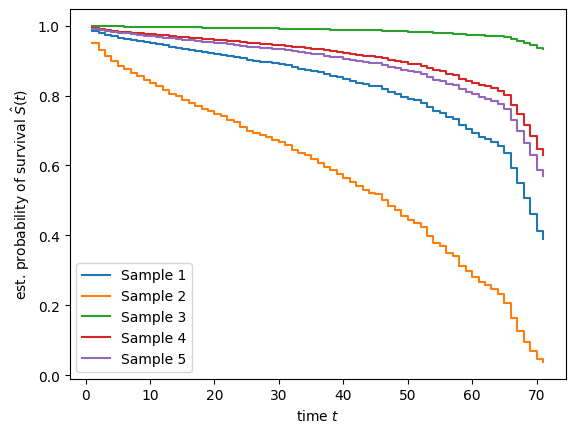

In [291]:
import numpy as np

pred_surv = estimator.predict_survival_function(X_test[:5])
time_points = np.arange(1, 72)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")


In [296]:
X_test_samples = X_test[:5]
y_test_samples = y_test[:5]

Para testar o modelo, selecionamos 5 elementos do conjunto de testes e realizamos apredição dos mesmos. É possivel observar que o "Sample 2" possui um comportamento de sobrevivência linear, quanto maior o tenure, menor a probabilidade de sobrevivência. Este comportamento pode indicar que o cliente precisará de alguma intervenção para evitar o churn ao longo do tempo.

#### Avaliação do modelo

Nossos dados de teste geralmente estão sujeitos à censura também, portanto, métricas como erro médio quadrático ou correlação são inadequadas. Em vez disso, utilizamos uma generalização da área sob a curva da característica de operação do receptor (ROC) chamada índice de concordância de Harrell ou c-index.

A interpretação é idêntica à métrica tradicional da área sob a curva ROC para classificação binária:

* um valor de 0,5 indica um modelo aleatório,
* um valor de 1,0 indica um modelo perfeito,
* um valor de 0,0 indica um modelo perfeitamente incorreto.

In [298]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_train)
result = concordance_index_censored(
    y_train['Churn'], y_train['tenure'], prediction)

result[0]


0.8646793921037483

In [299]:
prediction = estimator.predict(X_test)
result = concordance_index_censored(
    y_test['Churn'], y_test['tenure'], prediction)

result[0]


0.8708237549497456

Ao realizar a avaliação do modelo, obtivemos um c-index de 86,47% para o conjunto de treinamento e 87,08% para o conjunto de teste. Este resultado indica que o modelo possui uma boa capacidade de prever o tempo de ocorrência do evento. 

#### Explicabilidade do modelo

Nosso modelo de análise de sobrevivência foi treinado levando em consideração todas as variáveis disponíveis no conjunto de dados. No entanto, é possível que algumas variáveis não sejam relevantes para a previsão do tempo de ocorrência do evento. Pare identificar quais variáveis individualmente são as melhores preditoras de risco de churn, podemos treinar o modelo de riscos proporcionais de Cox para cada variável e comparar o c-index de cada modelo. Quanto maior o c-index, maior a capacidade da variável em prever o tempo de ocorrência do evento.


In [300]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(X_train.values, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

Contract_Month-to-month                    0.759252
OnlineSecurity_No                          0.678796
TechSupport_No                             0.676467
OnlineBackup_No                            0.662980
Contract_Two year                          0.659358
DeviceProtection_No                        0.654717
PaymentMethod_Electronic check             0.642893
Partner                                    0.629385
StreamingTV_No                             0.611342
OnlineSecurity_Yes                         0.609054
TechSupport_Yes                            0.606724
InternetService_Fiber optic                0.606028
StreamingMovies_No                         0.601624
Contract_One year                          0.599894
OnlineBackup_Yes                           0.593238
DeviceProtection_Yes                       0.584975
Dependents                                 0.582975
PaperlessBilling                           0.576954
PaymentMethod_Credit card (automatic)      0.576459
PaymentMetho

Com esta análise, podemos identificar que as variáveis "Contract", "PaymentMethod", "OnlineSecurity", "TechSupport", "InternetService" e "OnlineBackup" são as melhores preditoras de risco de churn. Deste modo, poderíamos utilizar estas variáveis para criar um modelo mais simples e explicável, que pode ser utilizado para prever o tempo de ocorrência do evento.

Por outro lado, as variáveis MultipleLines_No phone service, PhoneService e PaymentMethod_Mailed check não são boas preditoras de risco de churn. Deste modo, podemos remover estas variáveis do modelo para simplificar o mesmo. O fato de a variável PaymentMethod_Mailed check não ser uma boa preditora de risco de churn pode ter relação com o fato de ter um comportamento de churn acentuado nos dois primeiros meses de contrato, como observado no gráfico de sobrevivência com a variável PaymentMethod_Mailed check.